In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# sober x,y方向的卷积核
K_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
K_y = K_x.T

In [3]:
def corr2d(X: np.ndarray, K: np.ndarray, padding_same=False) -> np.ndarray:
    """二维互相关运算

    Args:
        X (np.ndarray): 原图 [H, W]
        K (np.ndarray): 卷积核 [K_H, K_W]
        padding_same (bool, optional): 是否padding为原图大小. Defaults to False.

    Returns:
        np.ndarray: 互相关结果 [H, W]
    """
    X_ = X.copy()
    h, w = K.shape
    if padding_same:
        pad_width = [(h//2, h//2), (w//2, w//2)]
        X_ = np.pad(X_, pad_width=pad_width, mode="constant", constant_values=0)
    Y = np.zeros((X_.shape[0] - h + 1, X_.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X_[i:i + h, j:j + w] * K).sum()
    return Y

In [4]:
def sober(X: np.ndarray, K: np.ndarray):
    conv_result = corr2d(X.astype(np.float32), K.astype(np.float32), padding_same=True)
    clip_result = np.clip(conv_result, 0, 255)
    return clip_result.astype(np.uint8)

# real image

(266, 474)


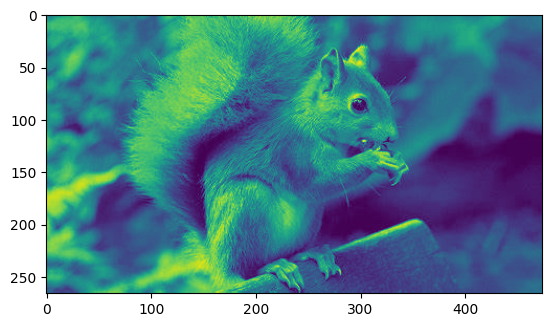

In [5]:
image = cv2.imread("squirrel.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print(image.shape)
plt.imshow(image)

[[255   2   0 ...  22  13   0]
 [255   0   0 ...  31  19   0]
 [255   0   0 ...  22  10   0]
 ...
 [255   0   0 ...  16  27   0]
 [255   0   0 ...  13  35   0]
 [255   0   0 ...   9  30   0]]


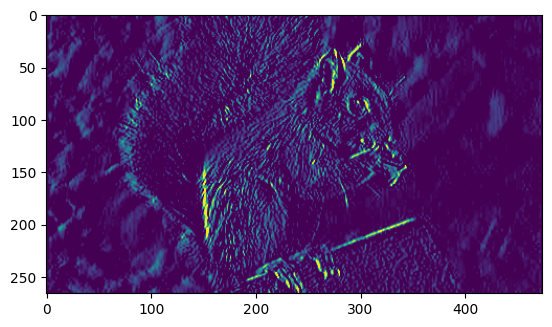

In [6]:
Y_x_1 = cv2.Sobel(
    src=image,
    ddepth=-1,  # 输出图像深度
    dx=1,       # X方向，几阶导数
    dy=0,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Y_x_1)
plt.imshow(Y_x_1)

[[255   2   0 ...  22  13   0]
 [255   0   0 ...  31  19   0]
 [255   0   0 ...  22  10   0]
 ...
 [255   0   0 ...  16  27   0]
 [255   0   0 ...  13  35   0]
 [255   0   0 ...   9  30   0]]


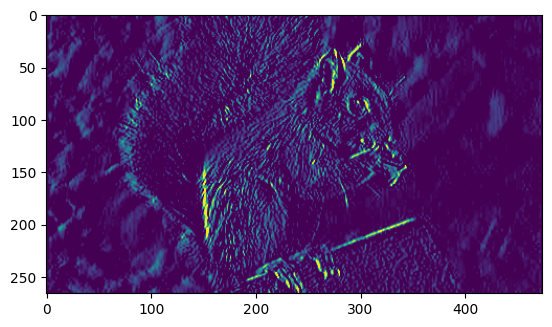

In [7]:
Y_x_2 = sober(image, K_x)
print(Y_x_2)
plt.imshow(Y_x_2)

In [8]:
# 复现成功
np.all(Y_x_1 == Y_x_2)

True

[[255 255 255 ... 255 255 255]
 [  0   0   0 ...   0   0   0]
 [ 42  46  32 ...   0   0   0]
 ...
 [ 69  57  29 ...  10  11  14]
 [ 52  38  18 ...   5   9  14]
 [  0   0   0 ...   0   0   0]]


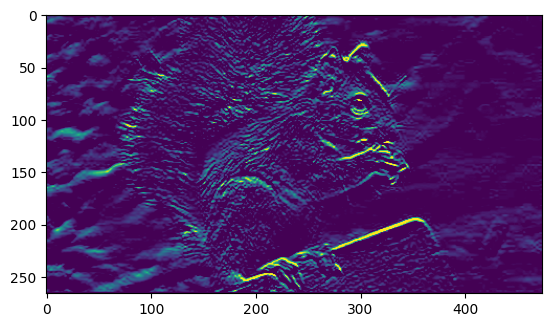

In [9]:
Y_y_1 = cv2.Sobel(
    src=image,
    ddepth=-1,  # 输出图像深度
    dx=0,       # X方向，几阶导数
    dy=1,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Y_y_1)
plt.imshow(Y_y_1)

[[255 255 255 ... 255 255 255]
 [  0   0   0 ...   0   0   0]
 [ 42  46  32 ...   0   0   0]
 ...
 [ 69  57  29 ...  10  11  14]
 [ 52  38  18 ...   5   9  14]
 [  0   0   0 ...   0   0   0]]


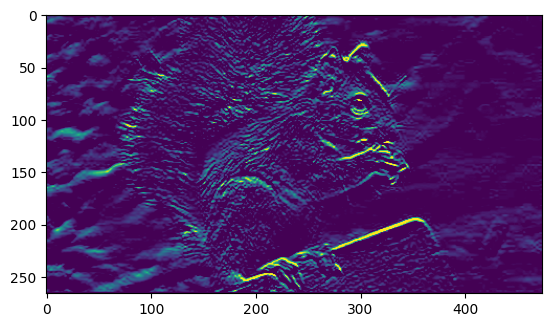

In [10]:
Y_y_2 = sober(image, K_y)
print(Y_y_2)
plt.imshow(Y_y_2)

In [11]:
# 复现成功
np.all(Y_y_1 == Y_y_2)

True

# random image

In [12]:
X = np.random.randint(0, 256, (10, 10), dtype=np.uint8)
X

array([[179, 146, 111, 205, 160, 105, 216,  60,  38,  39],
       [113, 133,  62, 112,  51,  77, 196, 179,  78, 232],
       [ 98, 229, 127,  47, 172, 211,  68, 238,  15, 179],
       [219, 228, 242, 106, 158,   5, 221,  21,  40, 217],
       [ 34,  33, 132,  72, 104, 185, 154,  51, 183,  86],
       [167,  40,  93, 153, 117,  88,  18,  57, 141,  95],
       [209,  44, 163,  93, 193,  23, 155,  74,   2,  79],
       [132, 103, 102, 254, 113, 242,   4, 226, 218, 115],
       [182,  32, 229, 199, 229, 215,  13,  66,  48, 250],
       [185,  13, 198,   6, 187, 246, 203,   7, 178, 108]], dtype=uint8)

[[255   0  97  87   0 255  12   0  11   0]
 [255   0   0  72   0 242 186   0  26   0]
 [255  30   0   0 192   0 172   0 131   0]
 [255 173   0   0  75  72   0   0 255   0]
 [255 145  69   0  60  64   0   0 255   0]
 [157   0 255  50   0   0   0 122 116   0]
 [231   0 255  95   0   0  55  31   0   0]
 [255   0 255  52   0   0   0 255   0   0]
 [180  77 255   0 255   0   0 255 255   0]
 [ 58  73 153   0 255   0   0   0 255   0]]


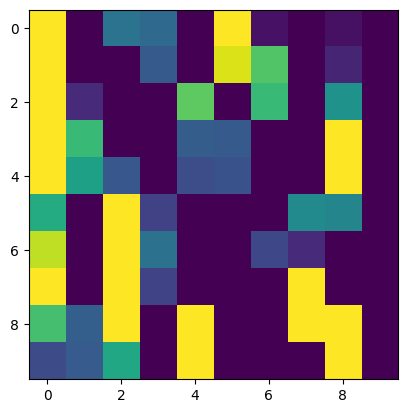

In [13]:
Y_x_1 = cv2.Sobel(
    src=X,
    ddepth=-1,  # 输出图像深度
    dx=1,       # X方向，几阶导数
    dy=0,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Y_x_1)
plt.imshow(Y_x_1)

[[255   0  97  87   0 255  12   0  11   0]
 [255   0   0  72   0 242 186   0  26   0]
 [255  30   0   0 192   0 172   0 131   0]
 [255 173   0   0  75  72   0   0 255   0]
 [255 145  69   0  60  64   0   0 255   0]
 [157   0 255  50   0   0   0 122 116   0]
 [231   0 255  95   0   0  55  31   0   0]
 [255   0 255  52   0   0   0 255   0   0]
 [180  77 255   0 255   0   0 255 255   0]
 [ 58  73 153   0 255   0   0   0 255   0]]


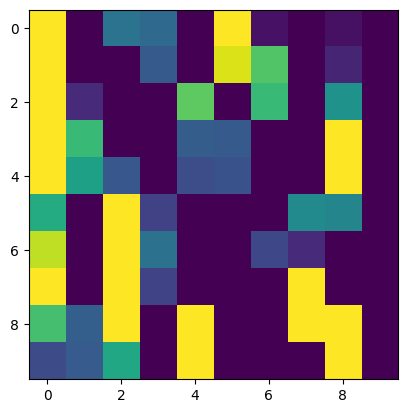

In [14]:
Y_x_2 = sober(X, K_x)
print(Y_x_2)
plt.imshow(Y_x_2)

In [15]:
# 复现成功
np.all(Y_x_1 == Y_x_2)

True

[[255 255 255 255 255 255 255 255 255 255]
 [  0 101   0   0   0  76   0 185 255 255]
 [255 255 255 255 136   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  56   0]
 [  0   0   0   0  48   0   0   0 116   0]
 [255 228  94 162  37   0   0   0   0   0]
 [  0 100 182 207 247 255 255 255 255 117]
 [  0  15 226 255 255 255   0   0 255 255]
 [ 16   0   0   0   0 255 183   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


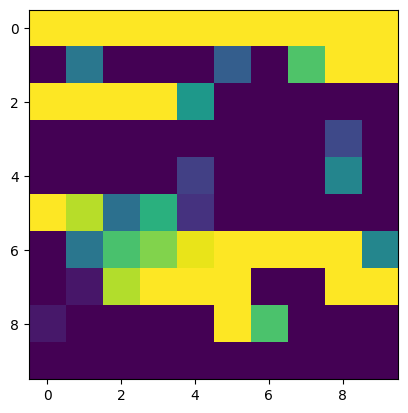

In [16]:
Y_y_1 = cv2.Sobel(
    src=X,
    ddepth=-1,  # 输出图像深度
    dx=0,       # X方向，几阶导数
    dy=1,       # Y方向，几阶导数
    ksize=3,    # SOBEL算子kernel大小，必须是奇数
    scale=1,
    delta=0,
    borderType=cv2.BORDER_CONSTANT,
)
print(Y_y_1)
plt.imshow(Y_y_1)

[[255 255 255 255 255 255 255 255 255 255]
 [  0 101   0   0   0  76   0 185 255 255]
 [255 255 255 255 136   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  56   0]
 [  0   0   0   0  48   0   0   0 116   0]
 [255 228  94 162  37   0   0   0   0   0]
 [  0 100 182 207 247 255 255 255 255 117]
 [  0  15 226 255 255 255   0   0 255 255]
 [ 16   0   0   0   0 255 183   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]]


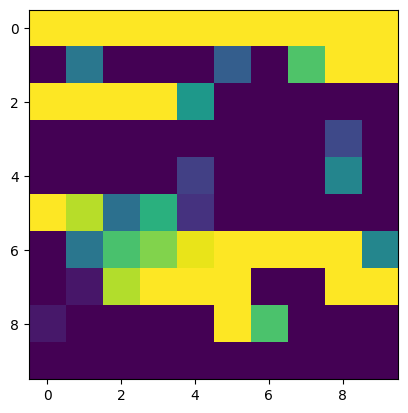

In [17]:
Y_y_2 = sober(X, K_y)
print(Y_y_2)
plt.imshow(Y_y_2)

In [18]:
# 复现成功
np.all(Y_y_1 == Y_y_2)

True